# 교통 데이터 VDS 전처리  
- 머신러닝 모델
- 딥러닝 모델 사용

## I. 데이터 가져오기 
- 판다스를 이용하여 교통 데이터 가져오기

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
import pandas as pd

In [3]:
import warnings
warnings.filterwarnings("ignore")

### 시계열 데이터 다루기
- RNN 실습시 필요함. 일단 받아들이세요.
- 시계열 데이터 : 년도-월-일 시간:분:초

In [4]:
df = pd.read_csv('./daejeon_vds16.csv')
df.head()

,Date,ToVol,SmVol,MeVol,LaVol,Speed,Occ.Rate
0,2017-04-02 0:00,43,34,9,0,50.3,1.90
1,2017-04-02 0:05,45,32,13,0,58.9,1.84
2,2017-04-02 0:10,46,34,12,0,50.6,1.87
3,2017-04-02 0:15,45,36,9,0,50.9,1.72
4,2017-04-02 0:20,27,13,13,1,62.2,1.12


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001B72A60C948>],
      dtype=object)

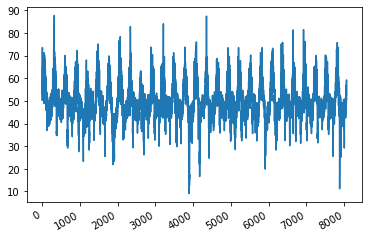

In [5]:
# 교통량 그림 그려보기
df_plt = df['Speed']
df_plt.plot(subplots=True)

- 5분 간격 데이터를 하루 동안 수집하면 그 갯수는 12(1시간) * 24 = 288
- 하루 동안 데이터를 그려보자 

## II. 라벨을 정하기
- 지도학습을 위해서 데이터를 Feature와 Label로 나누자.
- 무엇이 Feature이며 무엇이 Label 인가?
- 라벨은 무엇으로 정하는게 좋은가? 

In [6]:
def get_score(v):
    if v < 20:
        score = 'Jam'
    elif v < 40:
        score = 'Slow'
    else :
        score = 'Normal'
    return score

In [7]:
df["label_speed"] = df["Speed"].apply(lambda v: get_score(v))
df.head(5)

,Date,ToVol,SmVol,MeVol,LaVol,Speed,Occ.Rate,label_speed
0,2017-04-02 0:00,43,34,9,0,50.3,1.90,Normal
1,2017-04-02 0:05,45,32,13,0,58.9,1.84,Normal
2,2017-04-02 0:10,46,34,12,0,50.6,1.87,Normal
3,2017-04-02 0:15,45,36,9,0,50.9,1.72,Normal
4,2017-04-02 0:20,27,13,13,1,62.2,1.12,Normal


### 라벨을 위해 'label'의 텍스트는 범주형 혹은 숫자로 인코딩 해야한다

## 3. 데이터 가시화 

In [8]:
import matplotlib.pyplot as plt

In [9]:
import seaborn as sns

## 4 머신러닝을 위한 입력 데이터 만들자
- 우선 무슨 문제를 풀어야 하는가?
- 지도학습이며 라벨이 있고, 제일 먼저 해보는 것은 분류를 해보자
- 즉, 교통 속도 라벨을 이용하여 해당 도로의 교통 흐름을 분류해보고 정확도를 논의하자

### 1) 입력 X와 출력 y의 값을 정하기

In [10]:
df['label_speed'].unique()

array(['Normal', 'Slow', 'Jam'], dtype=object)

- 머신러닝에서 특징(Feature)에 대하여, 그리고 라벨에 대하여 다시한번 복습합시다 

In [11]:
#feature_cols = ['ToVol', 'SmVol', 'Speed', 'Occ.Rate']
#feature_cols = ['ToVol', 'SmVol', 'LaVol', 'MeVol']
feature_cols = ['ToVol']
target_col = 'label_speed'
X = df[feature_cols]
y = df[target_col]

In [12]:
X.head()

,ToVol
0,43
1,45
2,46
3,45
4,27


y = df['Species']

In [13]:
y.head()

0    Normal
1    Normal
2    Normal
3    Normal
4    Normal
Name: label_speed, dtype: object

### 2) 출력용 라벨을 머신러닝 
- 텍스트를 숫자로 바꾸자
- One-Hot Encoding
- 자연어 처리에는 Embedding을 사용함. 
- Word2Vec 

In [14]:
class_dic = {'Jam':0, 'Slow':1, 'Normal':2}
y_ohc = y.apply(lambda z: class_dic[z])

In [15]:
y_ohc.head()

0    2
1    2
2    2
3    2
4    2
Name: label_speed, dtype: int64

### 3) 데이터를 훈련과 테스트로 나누자 
- (실전) 데이터를 validation을 포함해서 나눌수 있다.
- (해보기) 전체 데이터를 train : validation : test = 0.6: 0.2: 0.2 로 나누어라

In [16]:
from sklearn.model_selection import train_test_split

#from sklearn.model_selection import learning_curve, train_test_split, KFold,  ShuffleSplit

X_train, X_test, y_train, y_test = train_test_split(X, y_ohc, test_size=0.20, random_state=30)

In [17]:
print(X_train.shape, y_train.shape)
print(X_test.shape,  y_test.shape)

(6451, 1) (6451,)
(1613, 1) (1613,)


- 머신러닝에서는 훈련과정에서 입력 특징 데이터를 표준화, 정규화를 한다.
- 왜?

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 5. 머신러닝 모델을 만들자

In [19]:
#from sklearn.model_selection import ShuffleSplit

### 0) 머신러닝 훈련과정을 그려보자

### 1) 로지스틱 회귀
- 로짓 함수는 Sigmoid를 사용하며, 분류와 회귀가 유사하다.

In [20]:
from sklearn.linear_model import LogisticRegression  

In [21]:
m_lr = LogisticRegression()

In [22]:
m_lr.fit(X_train,y_train)

LogisticRegression()

In [23]:
from sklearn import metrics   

In [24]:
pred = m_lr.predict(X_test)

In [25]:
acc_lr = metrics.accuracy_score(pred,y_test)
print('The accuracy of the Logistic Regression is', acc_lr)

The accuracy of the Logistic Regression is 0.9268443893366398


In [43]:
from sklearn.model_selection import ShuffleSplit

In [44]:
title = "Learning Curves (Logistic Regression)"
cv = ShuffleSplit(n_splits=4, test_size=0.2, random_state=0)

In [45]:
from sklearn.model_selection import learning_curve

In [46]:
from sklearn import metrics   

In [47]:
import numpy as np

In [50]:
def plot_ml_curve(scoring='mse', 
                  estimator, title, X, y, ylim=None, cv=None,n_jobs=None, train_sizes=np.linspace(.1, 1.0, 20)):   
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        scoring='neg_mean_squared_error',
        estimator, 
        X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_mean - train_std,
                     train_mean + train_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_mean - test_std,
                     test_mean + test_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc='lower right')
    return plt

SyntaxError: non-default argument follows default argument (Temp/ipykernel_33184/1776410848.py, line 1)

In [42]:
#import myUtil as myutil
plot_ml_curve(scoring='neg_mean_squared_error'
              m_lr, mse,title, X, y, ylim=(0.6, 1.01), cv=cv)

SyntaxError: invalid syntax (Temp/ipykernel_33184/654921275.py, line 3)

In [31]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)
    

In [32]:
from sklearn.linear_model import LogisticRegression  

In [33]:
#lin_reg = LogisticRegression()
#plot_ml_curve(m_lr, title, X, y, ylim=(0.6, 1.01), cv=cv)
plot_learning_curves(m_lr, X, y)
plt.axis([0, 80, 0, 3])                         # not shown in the book
save_fig("underfitting_learning_curves_plot")   # not shown
plt.show() 

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 'Normal'